In [112]:
import pandas as pd
import tweepy
import time
from tqdm import tqdm
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from nltk.tokenize import SpaceTokenizer
from nltk.stem import *
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import roc_curve, auc
from sklearn.svm import LinearSVC
from sklearn import metrics
from sklearn.linear_model import LogisticRegression

In [ ]:
df = pd.read_csv('/content/pl_covid_tweets_clean.txt', sep='\t')
#df.head()

FileNotFoundError: ignored

In [ ]:
id_list = df['tweet_id'].tolist()

In [ ]:
print(len(id_list))

583805


In [ ]:
CONSUMER_KEY = "05Q..."
CONSUMER_SECRET = "H1D..."
OAUTH_TOKEN = "147..."
OAUTH_TOKEN_SECRET = "VvP..."

In [ ]:
auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
auth.set_access_token(OAUTH_TOKEN, OAUTH_TOKEN_SECRET)
api = tweepy.API(auth)

In [ ]:
 chunked_list = list()
 chunk_size=100
 for i in range(0,len(id_list), chunk_size):
   chunked_list.append(id_list[i:i+chunk_size])
 print(len(chunked_list))

5839


In [ ]:
 tweets_list =[]
 for chunk in tqdm(chunked_list):
   while True:
     try:
       r = api.statuses_lookup(chunk)
       break
     except:
       time.sleep(1) 
   for tweet in r:
     tweets_list.append(tweet.text)

100%|██████████| 5839/5839 [1:42:15<00:00,  1.05s/it]


In [113]:
 df = pd.DataFrame({
                    'tweety':tweets_list})
 df.to_csv('zum_tweety.csv', index=False)
 df.to_excel('zum_tweety.xlsx', index=False)

In [114]:
df = pd.read_excel('/content/zum_tweety.xlsx')

In [115]:
!wget https://raw.githubusercontent.com/bieli/stopwords/master/polish.stopwords.txt

--2022-01-16 14:40:10--  https://raw.githubusercontent.com/bieli/stopwords/master/polish.stopwords.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2016 (2.0K) [text/plain]
Saving to: ‘polish.stopwords.txt’

polish.stopwords.tx 100%[===================>]   1.97K  --.-KB/s    in 0s      

2022-01-16 14:40:10 (28.5 MB/s) - ‘polish.stopwords.txt’ saved [2016/2016]



In [116]:
stop =[]
with open("/content/polish.stopwords.txt", "r") as a_file:
  for line in a_file:
    stopword = line.strip()
    stop.append(stopword)

In [117]:
df["tweety"] = df["tweety"].str.lower()
df['tweety_orginalne'] = df['tweety'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [118]:
df['czyste_tweety']=''
#df.head()

,tweety,tweety_orginalne,czyste_tweety
0,"kiedy #coronavirus dotrze do polski, napotka o...","#coronavirus dotrze polski, napotka opór znako...",
1,kolejni polacy chcą wrócić z wuhan https://t.c...,kolejni polacy chcą wrócić wuhan https://t.co/...,
2,a tymczasem w wuhan odcięto od reszty świata o...,tymczasem wuhan odcięto reszty świata obszar p...,
3,@patrykwachowiec @kancelariasejmu nie zdziwię ...,"@patrykwachowiec @kancelariasejmu zdziwię się,...",
4,".@msz_rp: 19 polaków chce wrócić z wuhan, w am...",".@msz_rp: 19 polaków chce wrócić wuhan, ambasa...",


In [119]:
df['czyste_tweety'] = df['tweety_orginalne'].str.replace(r'http\S+', '')
df['czyste_tweety'] = df['czyste_tweety'].str.replace(r'@\S+', '')
df['czyste_tweety'] = df['czyste_tweety'].str.replace(r'[^\w\s]', '')
df['czyste_tweety'] = df['czyste_tweety'].str.replace(r'[0-9]+', '')
#df.head()

In [121]:
emotkikony = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)

In [122]:
for index, row in df.iterrows():
  tweet = row[2]
  tweet = emotkikony.sub(r'', tweet)
  df.at[index , 'czyste_tweety'] = tweet

In [124]:
df['czyste_tweety'] = df['czyste_tweety'].str.replace(r'(.)1+', r'1')
#df.head()

,tweety,tweety_orginalne,czyste_tweety
0,"kiedy #coronavirus dotrze do polski, napotka o...","#coronavirus dotrze polski, napotka opór znako...",coronavirus dotrze polski napotka opór znakomi...
1,kolejni polacy chcą wrócić z wuhan https://t.c...,kolejni polacy chcą wrócić wuhan https://t.co/...,kolejni polacy chcą wrócić wuhan
2,a tymczasem w wuhan odcięto od reszty świata o...,tymczasem wuhan odcięto reszty świata obszar p...,tymczasem wuhan odcięto reszty świata obszar p...
3,@patrykwachowiec @kancelariasejmu nie zdziwię ...,"@patrykwachowiec @kancelariasejmu zdziwię się,...",zdziwię się powiedzą listy pojechały chin wu...
4,".@msz_rp: 19 polaków chce wrócić z wuhan, w am...",".@msz_rp: 19 polaków chce wrócić wuhan, ambasa...",polaków chce wrócić wuhan ambasadzie rp peki...


In [127]:
df2 = df['czyste_tweety']
df2.to_excel('czyste_tweety.xlsx',index=False)

In [128]:
df2 = pd.read_excel('/content/czyste_tweety.xlsx')
vectorizer_cv = CountVectorizer(analyzer='word')
X_cv = vectorizer_cv.fit_transform(df2['czyste_tweety'])

In [129]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(X_cv)
df2['klaster'] = kmeans.predict(X_cv)

In [130]:
df2['Sentyment']=''
df2.loc[df2['klaster'] == 0 , 'Sentyment'] = 'Negatywny'
df2.loc[df2['klaster'] == 1 , 'Sentyment'] = 'Pozytywny'
#df2.head()

,czyste_tweety,klaster,Sentyment
0,coronavirus dotrze polski napotka opór znakomi...,0,Negatywny
1,kolejni polacy chcą wrócić wuhan,0,Negatywny
2,tymczasem wuhan odcięto reszty świata obszar p...,0,Negatywny
3,zdziwię się powiedzą listy pojechały chin wu...,0,Negatywny
4,polaków chce wrócić wuhan ambasadzie rp peki...,0,Negatywny


In [131]:
df2.to_excel('dane_w_klastrach.xlsx',index=False)

In [132]:
df2 = pd.read_excel('/content/dane_w_klastrach.xlsx')
#df2.head()

,czyste_tweety,klaster,Sentyment
0,coronavirus dotrze polski napotka opór znakomi...,0,Negatywny
1,kolejni polacy chcą wrócić wuhan,0,Negatywny
2,tymczasem wuhan odcięto reszty świata obszar p...,0,Negatywny
3,zdziwię się powiedzą listy pojechały chin wu...,0,Negatywny
4,polaków chce wrócić wuhan ambasadzie rp peki...,0,Negatywny


In [133]:
space_tokenizer = SpaceTokenizer()
df2['czyste_tweety'] = df2['czyste_tweety'].apply(space_tokenizer.tokenize)
#df2.head()

,czyste_tweety,klaster,Sentyment
0,"[coronavirus, dotrze, polski, napotka, opór, z...",0,Negatywny
1,"[kolejni, polacy, chcą, wrócić, wuhan, ]",0,Negatywny
2,"[tymczasem, wuhan, odcięto, reszty, świata, ob...",0,Negatywny
3,"[, , zdziwię, się, powiedzą, listy, pojechały,...",0,Negatywny
4,"[, , polaków, chce, wrócić, wuhan, ambasadzie,...",0,Negatywny


In [134]:
st = PorterStemmer()
def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return data
df2['czyste_tweety']= df2['czyste_tweety'].apply(lambda x: stemming_on_text(x))
#df2.head()

,czyste_tweety,klaster,Sentyment
0,"[coronavirus, dotrze, polski, napotka, opór, z...",0,Negatywny
1,"[kolejni, polacy, chcą, wrócić, wuhan, ]",0,Negatywny
2,"[tymczasem, wuhan, odcięto, reszty, świata, ob...",0,Negatywny
3,"[, , zdziwię, się, powiedzą, listy, pojechały,...",0,Negatywny
4,"[, , polaków, chce, wrócić, wuhan, ambasadzie,...",0,Negatywny


In [135]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [136]:
lm = nltk.WordNetLemmatizer()
def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return data
df2['czyste_tweety']= df2['czyste_tweety'].apply(lambda x: lemmatizer_on_text(x))
#df2.head()

,czyste_tweety,klaster,Sentyment
0,"[coronavirus, dotrze, polski, napotka, opór, z...",0,Negatywny
1,"[kolejni, polacy, chcą, wrócić, wuhan, ]",0,Negatywny
2,"[tymczasem, wuhan, odcięto, reszty, świata, ob...",0,Negatywny
3,"[, , zdziwię, się, powiedzą, listy, pojechały,...",0,Negatywny
4,"[, , polaków, chce, wrócić, wuhan, ambasadzie,...",0,Negatywny


In [137]:
df2.to_excel('ML_gotowy.xlsx', index=False)

In [138]:
x=df2.czyste_tweety
y=df2.klaster
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.05, random_state =42)
x_validation, x_test, y_validation, y_test = train_test_split(x_test, y_test, test_size = 0.5, random_state =42)

In [140]:
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=98000)
x_train = vectorizer.fit_transform(x_train.apply(lambda x: ' '.join(x)))
print('Liczba słów charakterystycznych: ', len(vectorizer.get_feature_names()))

Liczba słów charakterystycznych:  98000


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [141]:
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=98000)
x_test = vectorizer.fit_transform(x_test.apply(lambda x: ' '.join(x)))
print('Liczba słów charakterystycznych: ', len(vectorizer.get_feature_names()))

Liczba słów charakterystycznych:  98000


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [145]:
def model_Evaluate(model):
  
  y_pred = model.predict(X_test)

  cf_matrix = confusion_matrix(y_test, y_pred)
  categories = ['Negatywne','Pozytywne']
  group_names = ['True Neg','False Pos', 'False Neg','True Pos']
  group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
  labels = [f'{v1} {v2}' for v1, v2 in zip(group_names, group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  sns.heatmap(cf_matrix, annot = labels, cmap = 'Greens',fmt = '',
  xticklabels = categories, yticklabels = categories)
  plt.xlabel("Przewidywane wartości", fontdict = {'size':14}, labelpad = 10)
  plt.ylabel("Aktualne wartości" , fontdict = {'size':14}, labelpad = 10)
  plt.title ("Matryca pomyłek", fontdict = {'size':18}, pad = 20)

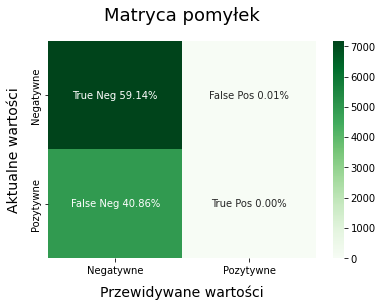

In [148]:
SVCmodel = LinearSVC()
SVCmodel.fit(x_train, y_train)
model_Evaluate(SVCmodel)
y_pred_svm = SVCmodel.predict(x_test)

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_svm)
roc_auc = metrics.auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='green', lw=1, label='Krzywa ROC (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Współczynnik False Positive')
plt.ylabel('Współczynnik True Positive')
plt.title('Krzywa ROC')
plt.legend(loc="lower right")
plt.show()

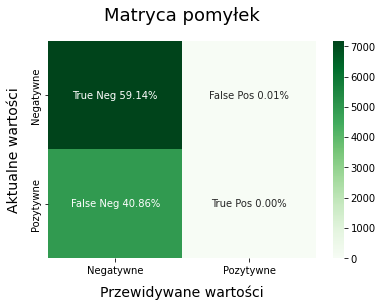

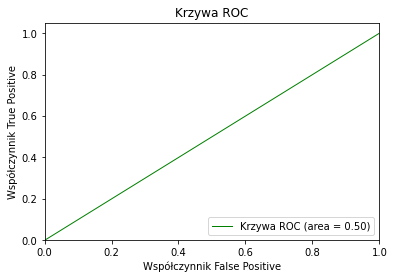

In [153]:
LRmodel = LogisticRegression(max_iter = 1000)
LRmodel.fit(x_train, y_train)
model_Evaluate(LRmodel)
y_pred_lr = LRmodel.predict(x_test)

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_lr)
roc_auc = metrics.auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='green', lw=1, label='Krzywa ROC (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Współczynnik False Positive')
plt.ylabel('Współczynnik True Positive')
plt.title('Krzywa ROC')
plt.legend(loc="lower right")
plt.show()

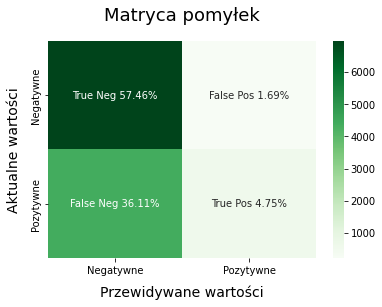

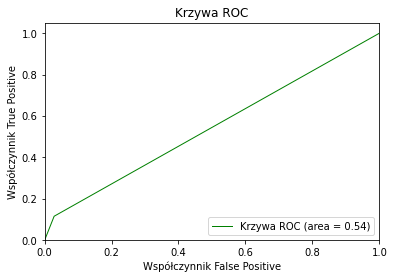

In [154]:
BNBmodel = BernoulliNB()
BNBmodel.fit(x_train, y_train)
model_Evaluate(BNBmodel)
y_pred_bayes = BNBmodel.predict(x_test)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_bayes)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='green', lw=1, label='Krzywa ROC (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Współczynnik False Positive')
plt.ylabel('Współczynnik True Positive')
plt.title('Krzywa ROC')
plt.legend(loc="lower right")
plt.show()